# Luminosity

In [2]:
from spice.models import IcosphereModel
from spice.spectrum import simulate_observed_flux
from spice.spectrum.spectrum import simulate_monochromatic_luminosity
import astropy.units as u
import jax.numpy as jnp
import numpy as np
from transformer_payne import Blackbody
import matplotlib.pyplot as plt
from synphot import SpectralElement
%matplotlib inline

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", False)

PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


Let's use a simple, blackbody model just for the testing purposes, alogside with a solar-like model.

In [3]:
bb = Blackbody()
model = IcosphereModel.construct(10000, 1., 1., [5772.], bb.parameter_names)

/Users/mjablons/Documents/stellar-mesh-integration/src/spice/models/mesh_model.py:222: UserWarning: If override_log_g is True, either parameter_names must include one of [logg,loggs,log_g,log_gs,log g,log gs,surface gravity,surface gravities,surface_gravity,surface_gravities], or log_g_index must be passed for log g to be used in the spectrum emulator.
  warnings.warn(f"If override_log_g is True, either parameter_names must include one of [" + ",".join(


In [4]:
jnp.sum(model.areas)/(4*jnp.pi)

Array(0.9997011, dtype=float32)

The model surface area matches the solar surface area calculated from the radius.

In [5]:
u.solRad.to(u.cm)**2*4*np.pi/np.power(u.pc.to(u.cm), 2)

6.3878216249461195e-15

To test the bolometric luminosity value, let's choose a wide range of wavelengths.

In [6]:
model.areas

Array([0.00056913, 0.00056926, 0.00056926, ..., 0.00073929, 0.00073929,
       0.00073992], dtype=float32)

In [34]:
vws = jnp.linspace(1., 10000000., 100000)

Text(0, 0.5, 'Intensity [erg/s/cm$^3$]')

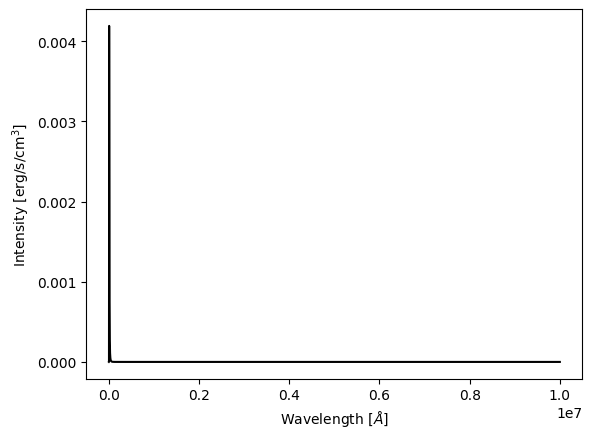

In [35]:
i_bb = np.nan_to_num(simulate_observed_flux(bb.intensity, model, jnp.log10(vws), chunk_size=256))/0.9997011
plt.plot(vws, i_bb[:, 0], color='black')
plt.gca().set_xlabel('Wavelength [$\\AA$]')
plt.gca().set_ylabel('Intensity [erg/s/cm$^3$]')

Now let's calculate the flux.

Text(0, 0.5, 'Flux')

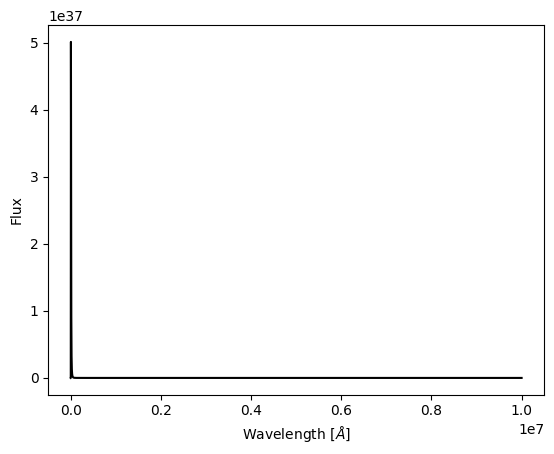

In [36]:
f_bb = simulate_monochromatic_luminosity(bb.flux, model, jnp.log10(vws), chunk_size=1000)
plt.plot(vws, f_bb[:, 0], color='black')
plt.gca().set_xlabel('Wavelength [$\\AA$]')
plt.gca().set_ylabel('Flux')

# Comparison with Synphot

In [37]:
from synphot.models import Empirical1D
from synphot import SourceSpectrum, units

bb_synphot = SourceSpectrum(Empirical1D, points=vws, lookup_table=np.nan_to_num(i_bb[:, 0]/1e8*units.FLAM))

FLAM is erg/s/cm^2/Angstrom per Steradian. I have converted it from our format of erg/s/cm^3 to erg/s/cm^2/Angstrom.

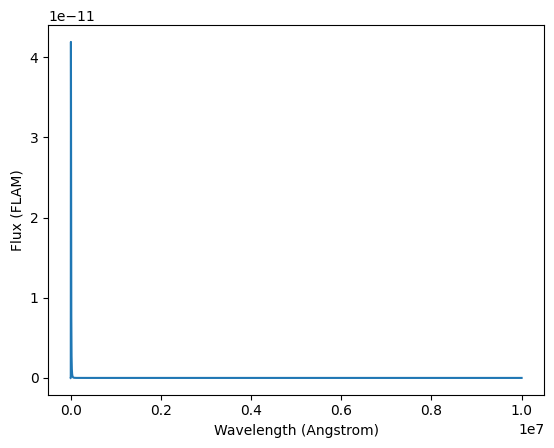

In [38]:
bb_synphot.plot(flux_unit=units.FLAM)

# Define the Johnson V filter myself in Synphot

In [39]:
from synphot import Observation
i = SpectralElement.from_filter('johnson_v') 
obs = Observation(bb_synphot, i, binset=vws)
obs.effstim(u.ABmag, wavelengths=vws)

<Magnitude 4.8733062 mag(AB)>

The Sun has a luminosity of 4.51 in this filter

# Filters

Let's use the ```Filter``` subclasses to check the passband luminosities.

In [40]:
from spice.spectrum.filter import *

In [41]:
bessel_b = BesselB()
bessel_i = BesselI()
gaia_g = GaiaG()
johnson_v = JohnsonV()

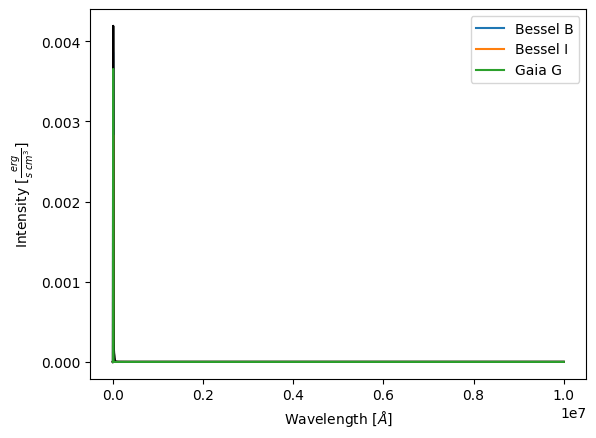

In [42]:
bessel_b.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])
bessel_i.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])
gaia_g.plot_filter_responses_for_wavelengths(vws, i_bb[:, 0])

The passband luminosities can be calculated using the ```AB_passband_luminosity``` function. Make sure to divide the observed luminosity by the distance first!

In [43]:
from spice.spectrum.spectrum import AB_passband_luminosity
C: float = 299792.458  # km/s

In [44]:
AB_passband_luminosity(johnson_v, vws, i_bb[:, 0])

Array(4.8605165, dtype=float32)

It should be 4.80

Comparison between the theoretical flux and the calculated flux - the calculated flux is incorrect...

In [45]:
np.sum(model.areas)

Array(12.562614, dtype=float32)

In [46]:
4*np.pi*(u.solRad.to(u.cm)**2)

6.082104402130212e+22

In [47]:
np.sum(np.where(model.mus>0., model.cast_areas, 0.))/(np.pi*u.solRad.to(u.cm)**2)

2.0654639592950993e-22

In [48]:
np.sum(model.areas), np.sum(model.cast_areas)

(Array(12.562614, dtype=float32), Array(6.281184, dtype=float32))

In [49]:
AB_passband_luminosity(johnson_v, vws, i_bb[:, 0]*(np.pi*u.solRad.to(u.cm)**2)/np.sum(np.where(model.mus>0., model.areas*model.mus, 0.)))

Array(-49.351948, dtype=float32)

In [50]:
(10*u.pc.to(u.cm))**2

9.521406136918413e+38

In [51]:
wave_cm = vws*1e-8 # 1 Angstrom = 1e-8 cm
T = 5777.
h = 6.62607015e-27  # Planck's constant [erg*s]
c = 2.99792458e10   # Speed of light [cm/s]
k = 1.380649e-16    # Boltzmann constant [erg/K]
# Compute blackbody intensity
intensity = ((2 * h * c ** 2 / wave_cm ** 5 * 1 / (jnp.exp(h * c / (wave_cm * k * T)) - 1)))*(np.pi*u.solRad.to(u.cm)**2)/((10*u.pc.to(u.cm))**2)

In [52]:
AB_passband_luminosity(
    johnson_v, vws, intensity-i_bb[:, 0])

Array(nan, dtype=float32)

In [53]:
np.max(intensity-i_bb[:, 0])

Array(nan, dtype=float32)

# TODO: debug cast areas?

In [54]:
solar_apparent_mag_B = AB_passband_luminosity(bessel_b, vws, i_bb[:, 0])
solar_apparent_mag_I = AB_passband_luminosity(bessel_i, vws, i_bb[:, 0])
solar_apparent_mag_G = AB_passband_luminosity(gaia_g, vws, i_bb[:, 0])
solar_johnson_v = AB_passband_luminosity(johnson_v, vws, i_bb[:, 0])

print("Apparent magnitude of the Sun")
print("Bessel B:\t", solar_apparent_mag_B, "mag")
print("Bessel I:\t", solar_apparent_mag_I, "mag")
print("Gaia G:\t\t", solar_apparent_mag_G, "mag")

print("Johnson V:\t\t", solar_johnson_v, "mag")

Apparent magnitude of the Sun
Bessel B:	 5.3813114 mag
Bessel I:	 4.5051656 mag
Gaia G:		 4.738237 mag
Johnson V:		 4.8605165 mag


In [55]:
AB_passband_luminosity(JohnsonU(), vws, i_bb[:, 0])

Array(6.1722064, dtype=float32)

# Bolometric luminosity of the Sun

The bolometric luminosity of the Sun is the energy that is outputted by the whole Sun. To calculate that, we need to obtain the total flux first.

In [56]:
from spice.spectrum import luminosity, absolute_bol_luminosity

In [57]:
solar_luminosity = luminosity(bb.flux, model, vws)
print("Sun's bolometric luminosity:", solar_luminosity, "erg/s")
print("Sun's absolute bolometric luminosity:", absolute_bol_luminosity(solar_luminosity), "mag")

Sun's bolometric luminosity: 3.8268478e+33 erg/s
Sun's absolute bolometric luminosity: 4.7403016 mag


Let's compare that to the theoretical luminosity:

$L=4\pi R^2 \sigma T^4$

In [62]:
sigma = (5.67*1e-8*u.W/(u.m**2)/(u.K**4)).to(u.erg/(u.cm**2)/(u.s)/(u.K**4))

print("Theoretical luminosity of the Sun:", 0.9997011*jnp.sum(model.areas)*(u.solRad.to(u.cm)**2)*sigma*(5772*u.K)**4, "erg/s")

Theoretical luminosity of the Sun: 3.8254498e+33 erg/s


In [69]:
3.8268478e+33/(3.8265937e+33)

1.0000664037052065

In [68]:
-2.5*np.log10(0.0000664037052065)

10.444519217775643

In [60]:
u.solLum.to(u.erg/u.s)

3.8279999999999997e+33